![logo](https://github.com/donatellacea/DL_tutorials/blob/main/notebooks/figures/1128-191-max.png?raw=true)

# Model-Agnostic Interpretation with SHAP for Image Analysis

In this Notebook we will demonstrate how to use the SHapley Additive exPlanations (SHAP) method and interpret its results for image classification models.

--------

## Getting Started

### Setup Colab environment

If you installed the packages and requirments on your own machine, you can skip this section and start from the import section.
Otherwise you can follow and execute the tutorial on your browser. In order to start working on the notebook, click on the following button, this will open this page in the Colab environment and you will be able to execute the code on your own.

<a href="https://colab.research.google.com/github/HelmholtzAI-Consultants-Munich/Zero2Hero---Introduction-to-XAI/blob/master/xai-model-agnostic/Tutorial_SHAP_Images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Now that you are visualizing the notebook in Colab, run the next cell to install the packages we will use.
There are few things you should follow in order to properly set the notebook up:

1. Warning: This notebook was not authored by Google. *Click* on 'Run anyway'.
2. When the installation commands are done, there might be "Restart runtime" button at the end of the output. Please, *click* it. 

In [1]:
# %pip install shap

By running the next cell you are going to create a folder in your Google Drive. All the files for this tutorial will be uploaded to this folder. After the first execution you might receive some warning and notification, please follow these instructions:
1. Permit this notebook to access your Google Drive files? *Click* on 'Yes', and select your account.
2. Google Drive for desktop wants to access your Google Account. *Click* on 'Allow'.

At this point, a folder has been created and you can navigate it through the lefthand panel in Colab, you might also have received an email that informs you about the access on your Google Drive. 

In [2]:
# Create a folder in your Google Drive
# from google.colab import drive                                                                          
# drive.mount('/content/drive')

In [3]:
# Don't run this cell if you already cloned the repo 
# !git clone https://github.com/HelmholtzAI-Consultants-Munich/XAI-Tutorials.git

In [4]:
# %cd XAI-Tutorials/xai-model-agnostic

### Imports

Let's start with importing all required Python packages.

In [1]:
import torch, torchvision
from torchvision import datasets, transforms
from torch import optim


import numpy as np
import shap
import joblib
import matplotlib.pyplot as plt
import random
import utils

# add Net model to path
import sys  
sys.path.append('../data_and_models/')
from model_net import Net

Now, we fix the random seeds to ensure reproducible results, as we work with (pseudo) random numbers.

In [9]:
# assert reproducible random number generation
seed = 2
np.random.seed(seed)
torch.manual_seed(seed)
random.seed(seed)

--------

## The MNIST dataset: Data and Model Loading

Let's use the MNIST dataset to see how SHAP can be used to explain image classification models. The MNIST dataset contains images of handwritten digits with numbers from 0 to 9. 

<center><img src="https://github.com/HelmholtzAI-Consultants-Munich/XAI-Tutorials/blob/main/docs/source/_figures/dataset_digits.png?raw=true" width="700" /></center>

<font size=1> Source:
[Link](https://towardsdatascience.com/part-5-training-the-network-to-read-handwritten-digits-c2288f1a2de3)

Let's train a simple 2D CNN for a small number of epochs on our training images.

*Note: this a very basic model to showcase how SHAP works for image classification. If you want to know more about it check out the model in the data_and_model folder and other functions we used in the utils.*

In [10]:
# define the train/test dataloader, batch size and number of epochs for training.

batch_size = 128
num_epochs = 5
device = torch.device('cpu')

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('mnist_data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor()
                   ])),
    batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('mnist_data', train=False, transform=transforms.Compose([
                       transforms.ToTensor()
                   ])),
    batch_size=batch_size, shuffle=True)

# instantiate the model and call the train and test functions 
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

# start the training and testing process
for epoch in range(1, num_epochs + 1):
    utils.train(model, device, train_loader, optimizer, epoch)
    utils.test(model, device, test_loader)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.309319
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.257481
Train Epoch: 1 [25600/60000 (43%)]	Loss: 1.828923
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.905061
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.795729

Test set: Average loss: 0.0051, Accuracy: 8783/10000 (88%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.667661
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.763977
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.535311
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.621729
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.405337

Test set: Average loss: 0.0028, Accuracy: 9290/10000 (93%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.465148
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.566859
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.347913
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.373605
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.474412

Test set: Average loss: 0.0020, Accuracy: 9464/10000 (95%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.340611
Train Epoch: 4 [12800/60000 (21%)]	Lo

Great, now you trained your CNN model with a high accuracy of ~96%!  

Let's select some images from the whole dataset for computing the SHAP values.

In [11]:
batch = next(iter(test_loader))
images, labels = batch

X_train = images[:100]
X_test = images[100:103]
y_train = labels[:100]
y_test = labels[100:103]

## Now, what does my model actually think is important in the data?

We prepared a small [Introduction to SHAP](https://xai-tutorials.readthedocs.io/en/latest/_model_agnostic_xai/shap.html) for you, to help you understand how this method works.

Now lets use SHAP to get some insights into the image classification model we load below. The `shap.Explainer()` function uses the shap values to explain any machine learning model. In the SHAP library, there are multiple explainers that can be used to explain which features are important in an image for classification. Some of them are:
* [DeepExplainer](https://shap-lrjball.readthedocs.io/en/latest/generated/shap.DeepExplainer.html)
* [PartitionExplainer](https://shap-lrjball.readthedocs.io/en/latest/generated/shap.PartitionExplainer.html)
* [GradientExplainer](https://shap-lrjball.readthedocs.io/en/latest/generated/shap.GradientExplainer.html#shap.GradientExplainer)

All of the above use specific methods to approximate SHAP values for deep learning models. In this course, we will focus on the implementation of `shap.GradientExplainer()`,  which calculates Shapley values for CNN models in a fast and model-specific way. You can read more about each explainer in the [SHAP API](https://shap.readthedocs.io/en/latest/api.html#explainers).

**GradientExplainer**

We won't go into the details here but we will rather focus on the interpretation of the results. As a reference, we summarize the main concepts and we recommend reading the SHAP documentation and the book [Interpreting Machine Learning Models With SHAP](https://leanpub.com/shap) (Molnar 2022). 
Many models, including several neural networks, are gradient-based. This means that we can compute the gradient of the loss function with respect to the model input. When we can compute the gradient with respect to the input, we can use this information to calculate SHAP values more efficiently. There’s a connection between the Gradient Estimator and a method called Integrated Gradients (Sundararajan et al. 2017). Integrated Gradients is a feature attribution method also based on gradients that outputs the integrated path of the gradient with respect to a reference point as an explanation. The difference between Integrated Gradients and SHAP values is that Integrated Gradients use a single reference point, while Shapley values utilize a background data set.

*Note: this method is a **local** method which means that it does only provide explanations for individual samples. However, the individual explanations can be used to also get **global** interpretations.*


### Step 1 - Create a baseline

We need to select a part of our data set to create a baseline, i.e. the background dataset to use for integrating our features. Here, we use our training set `x_train` as background dataset.

In [12]:
baseline = X_train

### Step 2 - Instantiate the class
We decided to focus on GradientExplainer which is implemented in the `shap.GradientExplainer()`.  
The first argument is the model (or a tuple containing the model and the layer that should be explained, which will return shap values for the input of the layer argument). The second argument is the baseline built with the background dataset.


In [13]:
explainer = shap.GradientExplainer(model, baseline)

### Step 3 - Compute SHAP values on a custom image

In the `shap_values()` method we pass the image(s) we want to explain as a tensor. We can set ranked_outputs=*n* we only explain the top *n* model outputs.

*Note: it can take some time to compute the SHAP values.*

In [14]:
# explain the model's predictions on the three samples of the test set
x_explain = X_test

shap_values = explainer.shap_values(x_explain)
shap_values = [np.swapaxes(np.swapaxes(s, 2, 3), 1, -1) for s in shap_values] # unroll the axes

#### Step 4 - Plot results

For every output node in the model, we get a one explanation for each output, i.e. our model has 10 outputs, hence, we get a list of 10 explanations.

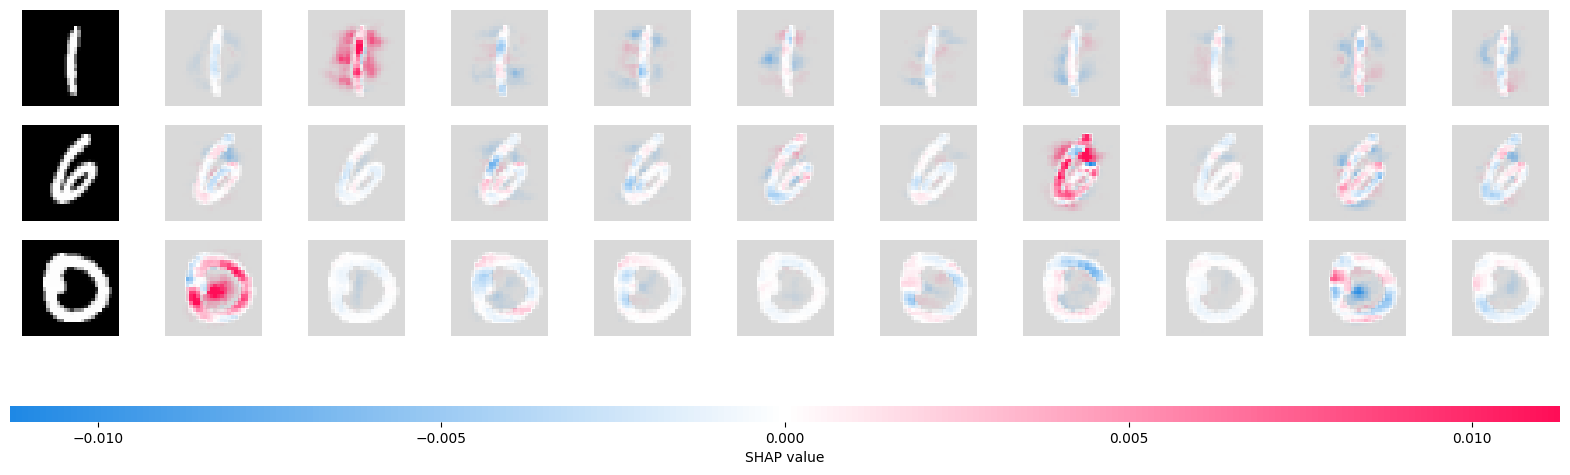

In [15]:
# here we plot the explanations for all classes for the first input (this is the feed forward input)
to_plot_x_explain = np.array(x_explain)
to_plot_x_explain = to_plot_x_explain.swapaxes(-1,1).swapaxes(1, 2)

shap.image_plot(shap_values, to_plot_x_explain)

SHAP uses colors to explain attribution:
- Red pixels increase the probability of a class being predicted
- Blue pixels decrease the probability of a class being predicted

In the images above, the input images are shown on the left column and the other columns show the SHAP value for the classes from 1 to 9, with the original image nearly transparent grayscale backings behind each of the explanations. The sum of the SHAP values equals the difference between the expected model output (averaged over the background dataset) and the current model output.

<font color='green'>

#### Question 1: Try to read the plot and explain it.

<font color='grey'>

#### Your Answer:

One plausible explanation is that, in the case of the digit zero, the empty space in the center of the image significantly influences the prediction of the correct class. Conversely, for the eighth class, those same pixels appear blue because that vacant space would have been occupied.

Another valid interpretation is that, for the digit six, the absence of a connection in the top-right part of the number plays a pivotal role in the prediction

<font color='green'>

#### Question 2: Why is SHAP  considered a contrastive method?

Hint: think about the role of the baseline, can you think about other ways to create a baseline for images (image with no features)?

<font color='grey'>

#### Your Answer:

The key lies in the role of the baseline or reference dataset. In explainability methods like SHAP, each time we select a baseline or reference dataset, it effectively establishes a basis for contrast. It compares the features of the input data, such as an image with specific features, against those of a reference dataset, typically an image lacking those features. This contrastive approach enables the quantification of how much each feature contributes to the model's prediction in relation to the chosen baseline. This process significantly aids in comprehending the underlying behavior of the model. It's worth noting that attributions in SHAP are relative values, representing contributions compared to the selected baseline.  Therefore, this method is that the attributions are not absolute values, but they are the contributions compared to a baseline.

Another conceptual limitation is the choice of a baseline that might change the explanation we get [Sturmfels et al., 2020](https://distill.pub/2020/attribution-baselines/).

<font color='green'>

#### Question 3: What do you think are the strengths and weaknesses of SHAP on image classification?

<font color='grey'>

#### Your Answer: 
Pros:
- Model-agnostic: SHAP can be applied to any machine learning model, not limited to CNNs, making it versatile for different architectures.
- Global and local interpretability: SHAP provides both global and local interpretability, allowing you to understand feature importance for individual predictions and the model's overall behavior.
- Quantitative explanations: It assigns attribution values to each feature (e.g., pixels in an image), providing a quantitative measure of their impact on the model's decision.
- Consistency: SHAP values adhere to Shapley values, which have a solid theoretical foundation in cooperative game theory.

Cons:
- Computationally intensive: Computing SHAP values can be resource-intensive, especially for complex models and large datasets.
- Complexity: Understanding and implementing SHAP values may require a deeper understanding of the SHAP framework and concepts like cooperative game theory.
- Some approximation is required: For deep learning models, exact SHAP values are often infeasible to compute, so approximations are used, potentially leading to less precise explanations.
- The choice of baseline images can significantly affect SHAP results (or any method that relies on baselines) - [Sturmfels et al., 2020](https://distill.pub/2020/attribution-baselines/)

